<a href="https://colab.research.google.com/github/afraAntara/590B/blob/main/RK4_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


In [ ]:
!pip install tensorflow==1.4


ERROR: Could not find a version that satisfies the requirement tensorflow==1.4 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==1.4


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

class RungeKuttaNN:
    def __init__(self, timestep, t_init, t_end):
        self.timestep = timestep
        self.t_init = t_init
        self.t_end = t_end
        self.n_oppar = 0
        self.n_var = 0
        self.n_inputs = 0
        self.n_hidden1 = 20
        self.n_hidden2 = 20
        self.n_batches = 10
        self.bsize = 0
        self.train_epochs = 900
        self.dstep = 50
        self.lr = 0.0001
        self.test_ratio = 0.1
        self.bound = 0.000005
        self.test_prop = 0.2
        self.w1 = []
        self.w2 = []
        self.w3 = []
        self.b1 = []
        self.b2 = []
        self.b3 = []
        self.tf_w1 = []
        self.tf_w2 = []
        self.tf_w3 = []
        self.tf_b1 = []
        self.tf_b2 = []
        self.tf_b3 = []
        self.input_x = []
        self.input_y = []
        self.output = []
        self.data = []

    def __enter__(self):
        return self

    def __exit__(self, exception_type, exception_value, traceback):
        tf.compat.v1.reset_default_graph()

    def _tf_act_fun(self, y):
        return tf.nn.relu(y)

    def _tf_predict_dy(self, y, x):
        stack = tf.concat(values=[y, x], axis=1)
        layer_1 = tf.matmul(stack, self.tf_w1) + self.tf_b1
        layer_1 = self._tf_act_fun(layer_1)
        layer_2 = tf.matmul(layer_1, self.tf_w2) + self.tf_b2
        layer_2 = self._tf_act_fun(layer_2)
        out = tf.matmul(layer_2, self.tf_w3) + self.tf_b3
        return out

    def _tf_forward_pass(self, y, x):
        dt = self.timestep
        k1 = dt * self._tf_predict_dy(y, x)
        k2 = dt * self._tf_predict_dy(y + k1 / 2, x)
        k3 = dt * self._tf_predict_dy(y + k2 / 2, x)
        k4 = dt * self._tf_predict_dy(y + k3, x)
        out = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        return out

    def _act_fun(self, y):
        """Activation function for prediction
        So far only using sigmoid, tanh and ReLU
        :param y: variable vector to be fed into activation function
        :return: f(y) where f is the activation function
        """
        #return np.tanh(y)
        #return 1.0/(1 + np.exp(-y))
        return np.fmax(0.0, y)

    def _predict_dy(self, y, x):
        """Predict F(y,x) as in y' = dy/dt = F(y,x)

        :param y: variable vector
        :param x: operating parameters
        :return: F(y,x) according to the trained neural network
        """
        z = np.hstack((y, x))
        layer_1 = z @ self.w1 + self.b1
        layer_1 = self._act_fun(layer_1)
        layer_2 = layer_1 @ self.w2 + self.b2
        layer_2 = self._act_fun(layer_2)
        out = layer_2 @ self.w3 + self.b3
        return out

    def predict(self, y, x):
        """Forward pass along the RKNN or prediction y(t) -> y(t+1)

        :param y: variable vector at time step t ( or y(t) )
        :param x: operating parameters at time step t
        :return: variable vector at time step t+1 ( or y(t+1) )
        """
        dt = self.timestep
        k1 = dt * self._predict_dy(y, x)
        k2 = dt * self._predict_dy(y + k1 / 2, x)
        k3 = dt * self._predict_dy(y + k2 / 2, x)
        k4 = dt * self._predict_dy(y + k3, x)
        out = y + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        return out

    def predict_from_samples(self, y, x, num_it):
        """Multiple predict's: long time prediction

        :param y: variable vector at the FIRST time step
        :param x: operating parameter at first time step
        :param num_it: number of iteration desired to compute y_1, y_2 .. y_{num_it}
        :return: vector containing future time steps of length num_it
        """
        current_y = y
        current_x = x[0]
        pred_list = y
        for it in range(num_it - 1):
            pred_var = self.predict(current_y, current_x)
            pred_list = np.vstack((pred_list, pred_var))
            current_y = pred_var
            current_x = x[it+1]
        return pred_list

    def start_train(self, data_y, data_x, output_y):
        assert (data_y.shape == output_y.shape), \
            "Input variable shape (%f,%f) does not match output dimension (%f,%f)" \
            %(data_y.shape[0], data_y.shape[1], output_y.shape[0], output_y.shape[1])

        assert (data_y.shape[0] == data_x.shape[0]), \
            "Number of variable snapshots %f does not match number of parameter snapshots %f" \
            %(data_y.shape[0], data_x.shape[0])

        assert (self.test_ratio <= 1.0), "Test ratio %f should be smaller than 1" % self.test_ratio

        if data_y.ndim == 1:
            data_y = data_y.reshape((data_y.shape[0], 1))
        if data_x.ndim == 1:
            data_x = data_x.reshape((data_x.shape[0], 1))

        self.n_var = data_y.shape[1]
        self.n_oppar = data_x.shape[1]
        self.n_inputs = self.n_var + self.n_oppar

        self.output = output_y
        self.input_y = data_y
        self.input_x = data_x

        n_samples = self.input_y.shape[0]
        self.data = np.hstack((data_y, data_x))

        joint_input = np.hstack((self.input_y, self.input_x))

        # print("var-oppar-inputs", self.n_var, self.n_oppar, self.n_inputs)
        print("output",self.output)
        # print("input_y",self.input_y)
        # print("input_x",self.input_x)
        # print("data",self.data)
        print("n", n_samples)
        print("data",joint_input)

        train_input, test_input, \
        train_output, test_output = train_test_split(joint_input, self.output,
                                                     test_size=int(n_samples * self.test_ratio), random_state=42)

        n_train = train_input.shape[0]
        test_y = test_input[:, :self.n_var]
        test_x = test_input[:, self.n_var:]

        if self.bsize != 0:
            self.n_batches = int(n_train / self.bsize)
        else:
            self.bsize = int(n_train / self.n_batches)

        leftover = n_train - self.n_batches * self.bsize

        tf.compat.v1.disable_v2_behavior()

        x = tf.compat.v1.placeholder("float", [None, self.n_oppar], name="OperatingParameters")
        y = tf.compat.v1.placeholder("float", [None, self.n_var], name="ODEInputVariable")
        z = tf.compat.v1.placeholder("float", [None, self.n_var], name="ODEOutputVariable")

        self.tf_w1 = tf.Variable(tf.keras.initializers.glorot_normal()((self.n_inputs, self.n_hidden1)), name="w1")
        self.tf_w2 = tf.Variable(tf.keras.initializers.glorot_normal()((self.n_hidden1, self.n_hidden2)), name="w2")
        self.tf_w3 = tf.Variable(tf.keras.initializers.glorot_normal()((self.n_hidden2, self.n_var)), name="w3")

        self.tf_b1 = tf.Variable(tf.zeros([self.n_hidden1]), "b1")
        self.tf_b2 = tf.Variable(tf.zeros([self.n_hidden2]), "b2")
        self.tf_b3 = tf.Variable(tf.zeros([self.n_var]), "b3")

        pred = self._tf_forward_pass(y, x)

        pow_diff = tf.pow(pred - z, 2)
        loss = tf.reduce_sum(pow_diff)

        optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=self.lr).minimize(loss)

        epoch = 0
        train_loss = 50

        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            while train_loss > self.bound and epoch < self.train_epochs:
                epoch += 1
                rand_index = np.random.permutation(n_train)
                train_y = train_input[rand_index, :self.n_var].reshape((n_train, self.n_var))
                train_x = train_input[rand_index, self.n_var:].reshape((n_train, self.n_oppar))
                train_out = train_output[rand_index].reshape((n_train, self.n_var))
                for i in range(self.n_batches):
                    data_in_y = train_y[i * self.bsize:(i + 1) * self.bsize]
                    data_in_x = train_x[i * self.bsize:(i + 1) * self.bsize]
                    data_out = train_out[i * self.bsize:(i + 1) * self.bsize]
                    values = {y: data_in_y,
                              x: data_in_x,
                              z: data_out}
                    sess.run(optimizer, feed_dict=values)

                if leftover != 0:
                    data_in_y = train_y[-leftover:]
                    data_in_x = train_x[-leftover:]
                    data_out = train_output[-leftover:]
                    values = {y: data_in_y,
                              x: data_in_x,
                              z: data_out}
                    sess.run(optimizer, feed_dict=values)

                if epoch % self.dstep == 0:
                    values = {y: test_y.reshape((test_y.shape[0], self.n_var)),
                              x: test_x.reshape((test_x.shape[0], self.n_oppar)),
                              z: test_output.reshape((test_output.shape[0], self.n_var))}
                    test_loss = sess.run(loss, feed_dict=values)
                    print('Test Loss at step %s: \t%s' % (epoch, test_loss))

                    values = {y: train_y.reshape((train_y.shape[0], self.n_var)),
                              x: train_x.reshape((train_x.shape[0], self.n_oppar)),
                              z: train_out.reshape((train_out.shape[0], self.n_var))}
                    train_loss = sess.run(loss, feed_dict=values)
                    print('Train Loss at step %s: \t%s' % (epoch, train_loss))

                self.w1, self.w2, self.w3, self.b1, self.b2, self.b3 = sess.run([self.tf_w1, self.tf_w2, self.tf_w3,
                                                                                 self.tf_b1, self.tf_b2, self.tf_b3])


In [ ]:
import numpy as np

def ode_solution(t):
    """Sets 2D dynamical system
    """
    '''
    y1 = 10*np.cos(t*2*np.pi/100).reshape((t.shape[0],1))
    y2 = 3*np.sin(t*2*np.pi/100).reshape((t.shape[0],1))
    joint = np.hstack((y1,y2))
    '''
    y1 = (2*(np.cos(t) + t*np.sin(t))).reshape((t.shape[0],1))
    y2 = (2*(np.sin(t) - t*np.cos(t))).reshape((t.shape[0],1))
    joint = np.hstack((y1, y2))
    return joint


def set_data(timestep, t_init, t_end):
    t = np.arange(t_init, t_end, timestep)
    # Obtain ODE sol
    data = ode_solution(t)
    # Normalise
    mean = np.mean(data)
    data -= mean
    std = np.std(data)
    data /= std
    return data, mean, std

In [ ]:
from matplotlib import pyplot as plt

# def main():
"""Approximates solution of ODE's with RK NN
"""
# Time step parameters
timestep = 0.01
t_init = 0
t_end = 100
num_it = int((t_end-t_init)/timestep)

## Initialise neural network and set parameters
rk = RungeKuttaNN(timestep, t_init, t_end)
# Number of batches
rk.n_batches = 10
# Number of training epochs
rk.train_epochs = 2000
# Learning rate
rk.lr = 1e-3
# Error target
rk.bound = 5e-8
# Number of neurons in the first layer
rk.n_hidden1 = 20
rk.n_hidden2 = 20
#TODO: Parameters that can change : learning rate, #training epochs and number of hidden neurons
#TODO: Add dimensionality reduction techniques for big data
# Obtain experimental data and set main quantities
data, mean, std = set_data(timestep, t_init, t_end)
print("data", data)
n_samples = data.shape[0]
n_timesteps = n_samples-1
input_var = data[:n_timesteps]
print("input_var:", input_var, input_var.shape)
input_oppar = np.zeros((n_samples,1))   # Trivial parameter in this example
print("input_oppar:", input_oppar, input_oppar.shape)
output_var = data[1:]
print("output_var:", output_var, output_var.shape)
print(data[0], data[0].shape)

data [[ 0.02885859  0.0043653 ]
 [ 0.02885982  0.00436531]
 [ 0.02886349  0.00436536]
 ...
 [-1.27755604 -2.0819935 ]
 [-1.25675693 -2.09491688]
 [-1.23582753 -2.10763288]]
input_var: [[ 0.02885859  0.0043653 ]
 [ 0.02885982  0.00436531]
 [ 0.02886349  0.00436536]
 ...
 [-1.29822281 -2.06886411]
 [-1.27755604 -2.0819935 ]
 [-1.25675693 -2.09491688]] (9999, 2)
input_oppar: [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]] (10000, 1)
output_var: [[ 0.02885982  0.00436531]
 [ 0.02886349  0.00436536]
 [ 0.02886961  0.00436552]
 ...
 [-1.27755604 -2.0819935 ]
 [-1.25675693 -2.09491688]
 [-1.23582753 -2.10763288]] (9999, 2)
[0.02885859 0.0043653 ] (2,)


Instructions for updating:
non-resource variables are not supported in the long term


output [[ 0.02885982  0.00436531]
 [ 0.02886349  0.00436536]
 [ 0.02886961  0.00436552]
 ...
 [-1.27755604 -2.0819935 ]
 [-1.25675693 -2.09491688]
 [-1.23582753 -2.10763288]]
n 9999
data [[ 0.02885859  0.0043653   0.        ]
 [ 0.02885982  0.00436531  0.        ]
 [ 0.02886349  0.00436536  0.        ]
 ...
 [-1.29822281 -2.06886411  0.        ]
 [-1.27755604 -2.0819935   0.        ]
 [-1.25675693 -2.09491688  0.        ]]
Test Loss at step 50: 	0.00017740228
Train Loss at step 50: 	0.0015717985
Test Loss at step 100: 	4.3666838e-05
Train Loss at step 100: 	0.00038091198
Test Loss at step 150: 	2.359817e-05
Train Loss at step 150: 	0.00021156555
Test Loss at step 200: 	1.5613447e-05
Train Loss at step 200: 	0.00014043692
Test Loss at step 250: 	1.194243e-05
Train Loss at step 250: 	0.00010435867
Test Loss at step 300: 	9.493129e-06
Train Loss at step 300: 	7.968031e-05
Test Loss at step 350: 	7.648007e-06
Train Loss at step 350: 	6.1393526e-05
Test Loss at step 400: 	5.497319e-06
Train

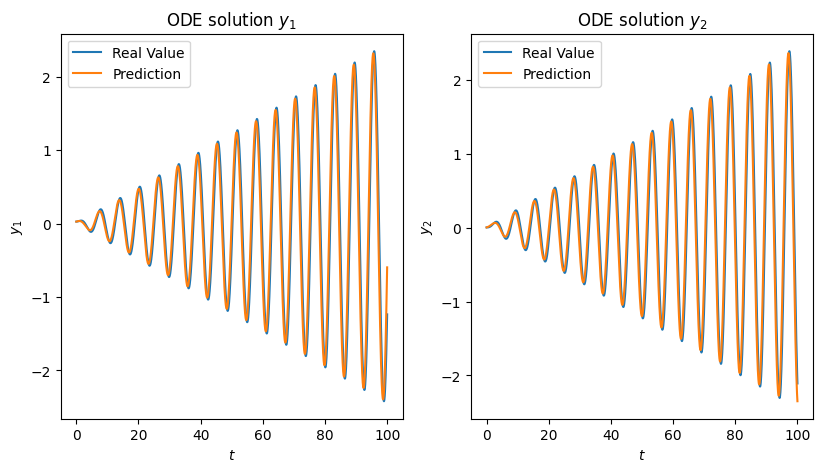

In [ ]:


# Start training
rk.start_train(input_var, input_oppar[:n_timesteps], output_var)

time_vals = np.arange(t_init, t_end, timestep)
pred = rk.predict_from_samples(y=data[0], x=input_oppar, num_it=num_it)

#TODO: Optional- denormalise prediction and original data with mean and std

# Plots
fig = plt.figure(figsize=(15, 5))

# ax = fig.add_subplot(131)
# plt.plot(data[:,0], data[:,1], label="Real Value")
# plt.plot(pred[:,0], pred[:,1], label="Prediction")
# plt.title(r"ODE solution $y' = F(x,y)$")
# plt.xlabel(r"$y_1$")
# plt.ylabel(r"$y_2$")
# plt.legend()

ax = fig.add_subplot(132)
plt.plot(time_vals, data[:, 0], label="Real Value")
plt.plot(time_vals, pred[:, 0], label="Prediction")
plt.title(r"ODE solution $y_1$")
plt.xlabel(r"$t$")
plt.ylabel(r"$y_1$")
plt.legend()

ax = fig.add_subplot(133)
plt.plot(time_vals, data[:, 1], label="Real Value")
plt.plot(time_vals, pred[:, 1], label="Prediction")
plt.title(r"ODE solution $y_2$")
plt.xlabel(r"$t$")
plt.ylabel(r"$y_2$")
plt.legend()

plt.show()


# if __name__ == '__main__':
#     main()